In [1]:
import Pkg; Pkg.activate(expanduser("~/Projects/goal-code"))

  Activating project at `~/Projects/goal-code`


In [2]:
#=
=====================================================
Script Name     : VS_lfp.jl
Autho=r          : Ryan Young
Created         : 05-03-2023
Last Modified   : 05-03-2023
===================================================

# Description
This script plots local field potential properties against timeshifted
optimal 𝛕 of each cell.
=#

using GoalFetchAnalysis
using DataFrames, DataFramesMeta, ProgressMeter, StatsBase, Statistics,
StatsPlots, Plots, LaTeXStrings, DirectionalStatistics
using DSP: angle
Base.angle(x::Missing) = missing
using LaTeXStrings
import Random, Pluto
using Infiltrator
import TranscodingStreams

[ Info: Precompiling GoalFetchAnalysis [6c9d06fb-25ba-4ee3-a449-584350dba86f]
[ Info: Skipping precompilation since __precompile__(false). Importing GoalFetchAnalysis [6c9d06fb-25ba-4ee3-a449-584350dba86f].


WebIO._IJuliaInit()

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception =
│    LoadError: UndefVarError: `FileIO` not defined
│    Stacktrace:
│      [1] include(mod::Module, _path::String)
│        @ Base ./Base.jl:457
│      [2] include(x::String)
│        @ Plots ~/.julia/packages/Plots/yJrrq/src/Plots.jl:1
│      [3] top-level scope
│        @ ~/.julia/packages/Plots/yJrrq/src/init.jl:80
│      [4] eval
│        @ ./boot.jl:370 [inlined]
│      [5] eval
│        @ ~/.julia/packages/Plots/yJrrq/src/Plots.jl:1 [inlined]
│      [6] (::Plots.var"#330#369")()
│        @ Plots ~/.julia/packages/Requires/Z8rfN/src/require.jl:101
│      [7] macro expansion
│        @ timing.jl:393 [inlined]
│      [8] err(f::Any, listener::Module, modname::String, file::String, line::Any)
│        @ Requires ~/.julia/packages/Requires/Z8rfN/src/require.jl:47
│      [9] (::Plots.var"#329#368")()
│        @ Plots ~/.julia/packages/Requires/Z8rfN/src/require.jl:100
│     [10] withpath(f::Any, path::String)
│    

Message "GoalFetchAnalysis.jl ready" sent successfully



In [ ]:
theme(:dark)

 Load data

In [3]:
animal, day = "super_clean", 0
CELLS  = DI.load_cells(animal, day, "*")
time_factors = DI.behavior_0time_before_process("super")
taus = names(CELLS)[occursin.("1of20", names(CELLS))]

# -------------------------------
# Copy pasta from setup_pyr_iso.jl
# -------------------------------
function get_data(animal, day)
    # l_pyr = DI.load_lfp(animal, day; append="pyr")
    # l_pyr = transform(l_pyr, :time=> t-> t .- time_factors[animal], renamecols=false)
    # transform!(l_pyr, :time=> t-> t .+ time_factors[animal], renamecols=false)
    println("Cycles")
    cycles = DI.load_cycles(animal, day, "pyr")
    cycles = transform(cycles,
        :start=> t-> t .- time_factors[animal],
        :stop => t-> t .- time_factors[animal],
        renamecols=false
    )
    # cycles = cycles[!,Not([:start_function,:stop_function])]
    println("Spikes")
    spikes = transform(DI.load_spikes(animal, day, "pyr_cycles_isolated"),
        :time=> t-> t .- time_factors[animal],
        renamecols=false
    )
    # spikes = subset(SPIKES, :animal=>a->a.==animal, :day=>d->d.==day)
    # Print out extrema(time) for each of these just to be sure
    begin
        println("spikes.time: ", extrema(spikes.time))
        # println("lfp.time: ", extrema(l_pyr.time))
        println("cycles.time: ", extrema(cycles.start))
    end
    println("Behavior")
    beh = transform(DI.load_behavior(animal, day),
        :time=> t-> t .- time_factors[animal],
        renamecols=false
    )
    DIutils.pushover("Loaded checkpoint for $animal")
    (;cycles, spikes, beh)
end
CYCLES, SPIKES, BEH = [], [], []
datasets = [("RY16",36), ("RY22",21)]
(animal, day) = first(datasets)
for (animal, day) in datasets
    if !isfile(DI.cyclepath(animal, day, "pyr"))
        continue
    end
    println("Loading $animal")
    cycles, spikes, beh = get_data(animal, day)
    println("Adding $taus to $animal")
    spikes = sort!(spikes, [:unit, :time])
    DIutils.filtreg.register(CELLS, spikes, on="unit", transfer=taus)
    sort!(beh,:time)
    sort!(spikes,:time)
    DIutils.filtreg.register(beh, spikes, on="time", transfer=["speedsmooth"])
    println("Done with $animal")
    push!(CYCLES, cycles)
    push!(SPIKES, spikes)
    push!(BEH, beh)
    # Transfer the tau values to the spikes
end
CYCLES = vcat(CYCLES...)
SPIKES = vcat(SPIKES...)
BEH = vcat(BEH...; cols=:union)

[ Info: Removing area_1
[ Info: Removing csi_1
[ Info: Removing hemisphere_1
[ Info: Removing index_1
[ Info: Removing meanrate_1
[ Info: Removing numspikes_1
[ Info: Removing propbursts_1
[ Info: Removing spikewidth_1
[ Info: Removing tag_1
[ Info: Removing tetrode_1
[ Info: Removing unitoftet_1
[ Info: Removing interneuron_1
[ Info: Removing celltype_1
[ Info: Removing bursting_parent_1
[ Info: Removing dur_sec_1
[ Info: Removing firing_rate_1
[ Info: Removing isolation_1
[ Info: Removing noise_overlap_1
[ Info: Removing num_events_1
[ Info: Removing overlap_cluster_1
[ Info: Removing peak_amp_1
[ Info: Removing peak_noise_1
[ Info: Removing peak_snr_1
[ Info: Removing t1_sec_1
[ Info: Removing t2_sec_1
[ Info: Removing msID_1
[ Info: Removing old_unit_1
[ Info: Removing animal_1
[ Info: Removing day_1
[ Info: Removing day_2
[ Info: Removing animal_2
┌ Info: cell types
│   interneurons = 10
└   pyr = 466
┌ Info: cell types
│   interneurons = 10
└   pyr = 466


Loading RY16
Cycles
Spikes
spikes.time: (-5145.194066666707, 19491.488200000007)
cycles.time: (-5145.1953f0, 19491.469f0)
Behavior


[ Info: NOT moving defined as smoothvel < 4cm/s || dio poke


Message "Loaded checkpoint for RY16" sent successfully

Adding ["all-1of20", "task-1of20", "correct-1of20", "error-1of20", "nontask-1of20", "memory-1of20", "cue-1of20", "evens-1of20", "arena-1of20", "home-1of20", "cue_correct-1of20", "cue_error-1of20", "mem_correct-1of20", "mem_error-1of20", "home_all-1of20", "home_task-1of20", "home_correct-1of20", "home_error-1of20", "home_memory-1of20", "home_cue-1of20", "home_evens-1of20", "home_cue_correct-1of20", "home_cue_error-1of20", "home_mem_correct-1of20", "arena_all-1of20", "arena_task-1of20", "arena_correct-1of20", "arena_error-1of20", "arena_memory-1of20", "arena_cue-1of20", "arena_evens-1of20", "arena_cue_correct-1of20", "arena_cue_error-1of20", "arena_mem_correct-1of20", "arena_mem_error-1of20", "none-1of20"] to RY16
Done with RY16
Loading RY22
Cycles
Spikes
spikes.time: (86162.91805833335, 154103.78365833333)
cycles.time: (-8254.572265625, 59686.33203124999)
Behavior


[ Info: NOT moving defined as smoothvel < 4cm/s || dio poke


Message "Loaded checkpoint for RY22" sent successfully

Adding ["all-1of20", "task-1of20", "correct-1of20", "error-1of20", "nontask-1of20", "memory-1of20", "cue-1of20", "evens-1of20", "arena-1of20", "home-1of20", "cue_correct-1of20", "cue_error-1of20", "mem_correct-1of20", "mem_error-1of20", "home_all-1of20", "home_task-1of20", "home_correct-1of20", "home_error-1of20", "home_memory-1of20", "home_cue-1of20", "home_evens-1of20", "home_cue_correct-1of20", "home_cue_error-1of20", "home_mem_correct-1of20", "arena_all-1of20", "arena_task-1of20", "arena_correct-1of20", "arena_error-1of20", "arena_memory-1of20", "arena_cue-1of20", "arena_evens-1of20", "arena_cue_correct-1of20", "arena_cue_error-1of20", "arena_mem_correct-1of20", "arena_mem_error-1of20", "none-1of20"] to RY22
Done with RY22


LoadError: ArgumentError: column(s) milk_4 and milk_5 are missing from argument(s) 1

 Analyze

Plot.setparentfolder("timeshift", "lfp")
INFO: Some ideas to try
- rank instead of actual
- individual spices instead of mean of their phases
- allowing different types of tau to co-occur
-

First, let's actually create views into the spikes that actually occur
in ripple and valid theta cycle
ISSUE: better filter theta cycles before this step?
-e.g. why theta in ripples -- violates assumption
- restrict to cells with significant coupling to the theta rhythm
- why some theta phases WAY over 1 or way less than 0

In [4]:
# Convert the two event phases [0, 1] to [0, 2π]
begin
    println(" ====  INITIAL  ====  ")
    println("Range of ripple_phase", extrema(SPIKES.ripple_phase|>skipmissing));
    println("Range of theta_phase", extrema(SPIKES.theta_phase|>skipmissing));
    println("Range of ripple_phase_band", extrema(SPIKES.ripple_phase_band|>skipmissing));
    println(" ================  ")
end
begin
    SPIKES.theta_phase = replace(SPIKES.theta_phase, NaN=>missing);
    SPIKES.tp   = 2π*SPIKES.theta_phase;
    SPIKES.spwp = 2π*SPIKES.ripple_phase;
    SPIKES.rp   = SPIKES.ripple_phase_band;
    SPIKES.theta_phase  = allowmissing(SPIKES.tp);
    SPIKES.ripple_phase = allowmissing(SPIKES.spwp);
    missing_inds = findall((SPIKES.theta_phase .> 2pi)|>skipmissing);
    SPIKES.theta_phase[missing_inds] .= missing;
    missing_inds = findall((SPIKES.ripple_phase .> 2pi)|>skipmissing);
    SPIKES.ripple_phase[missing_inds] .= missing;
    SPIKES.tp   = exp.(im*SPIKES.tp);
    SPIKES.spwp = exp.(im*SPIKES.spwp);
    SPIKES.rp   = exp.(im*SPIKES.rp);
end
begin
    println(" ====  FINAL ====  ")
    println("Range of ripple_phase", extrema(SPIKES.ripple_phase|>skipmissing));
    println("Range of theta_phase", extrema(SPIKES.theta_phase|>skipmissing));
    println("Range of ripple_phase_band", extrema(SPIKES.ripple_phase_band|>skipmissing));
end

 ====  INITIAL  ====  
Range of ripple_phase(0.0, 4.56083898368e11)
Range of theta_phase(NaN, NaN)
Range of ripple_phase_band(6.516827184555041e-7, 6.283184051513672)


LoadError: syntax: "begin" at In[40]:24 expected "end", got "12"

And let's also set any times with no ripples phases to `missing` and any poor $\theta$ times to `missing`

In [ ]:
# When there's no ripple, make sure these fields are `missing`
transform!(subset(SPIKES, :ripple => r->r .== 0, view=true),
    :ripple_time => x->x .* missing,
    :ripple_phase => x->x .* missing,
    :ripple_phase_band => x->x .* missing,
    :ripple_amp_band => x->x .* missing);

In [ ]:
transform!(subset(dropmissing(SPIKES, :theta ,view=true), 
    :theta => r->r .≈ 0, view=true),
    :theta_time => x->x .* missing,
    :theta_phase => x->x .* missing,
)

Let's check hypothetical theta `amplitude` and `speedsmooth`

In [5]:
h1=histogram(filter(x->x<80,BEH.speedsmooth)) 
vline!([4],c=:red, title=:speed, label="")
h2=histogram(SPIKES.theta_phase)
plot(h1,h2)

LoadError: InexactError: trunc(Int64, 4.761059167918976e40)

 Plotting

 SECTION: I. STRENGTH OF LOCKING OVER CELLS AND PER CELL

Plot module state:
------------------
Active: true
Plotdir: /home/ryoung/Projects/goal-code/plots/cell-strength-of-locking
Append: 
Prepend: 
------------------


┌ Info: saving
└   name = "/home/ryoung/Projects/goal-code/plots/cell-strength-of-locking/phase-distribution, all cells.png"
┌ Info: saving
└   name = "/home/ryoung/Projects/goal-code/plots/cell-strength-of-locking/phase-distribution, all cells.pdf"


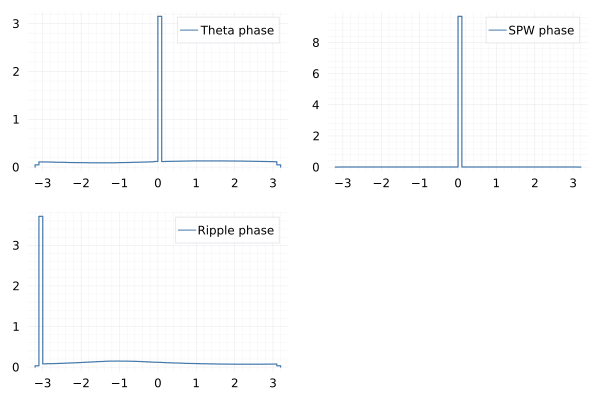

In [6]:
Plot.setfolder("cell-strength-of-locking")
function plot_spike_phases(sp::DataFrame; field=:spwp, name="ripple")
    r = Random.randperm(nrow(sp))
    n=min(1000, nrow(sp))
    samples = sp[r[1:n],:][!,field] |> skipmissing |> collect
    s=  scatter(real.(samples).+randn(size(samples,1)).*0.1,
        imag.(samples)+randn(size(samples,1)).*0.1, ms=1,
        label=""
    )
    X=[0+0im; mean(sp[!,field]|>skipmissing|>collect)]
    # Y = imag(X);
    # X = real(X);
    plot!(real(X), imag(X), color=:black, label="$(nrow(sp)) spikes))")
    scatter!([real(X)[end]], [imag(X)[end]], color=:black, label="", ms=7)
    Plot.save("$name-phase-of-spikes_cell=$(first(sp.unit))")
    s
end
plot(
    histogram(SPIKES.tp.|>angle, bins=100, normed=true,
        label="Theta phase"),
    histogram(SPIKES.spwp.|>angle, bins=100, normed=true,
        label="SPW phase"),
    histogram(SPIKES.rp.|>angle, bins=100, normed=true,
        label="Ripple phase"),
)
Plot.save("phase-distribution, all cells")
current()

 SUBSECTION: I.A UNIT CIRCLE PLOTS

In [ ]:
# SPW
    P = []
    unit = first(unique(SPIKES.unit))
    Plot.pushfolder("cells-spw")
    for unit in unique(SPIKES.unit)
        push!(P,plot_spike_phases(SPIKES[SPIKES.unit.==unit,:], field=:spwp,
                name="spw"))
    end
    Plot.popfolder()
    plot(P[1:50]..., size=(2000,2000), ms=1)
    Plot.save("MANY-CELL_spw-phase-of-spikes")
# THETA
    P = []
    unit = first(unique(SPIKES.unit))
    Plot.pushfolder("cells-theta")
    for unit in unique(SPIKES.unit)
        push!(P,plot_spike_phases(SPIKES[SPIKES.unit.==unit,:], field=:tp,
        name="theta"))
    end
    Plot.popfolder()
    plot(P[1:50]..., size=(2000,2000), ms=1)
    Plot.save("MANY-CELL_theta-phase-of-spikes")
# RIPPLE
    P = []
    unit = first(unique(SPIKES.unit))
    Plot.pushfolder("cells-ripple")
    for unit in unique(SPIKES.unit)
        push!(P,plot_spike_phases(SPIKES[SPIKES.unit.==unit,:], field=:rp, 
                name="ripple"))
    end
    Plot.popfolder()
    plot(P[1:50]..., size=(2000,2000), ms=1)
    Plot.save("MANY-CELL_ripple-phase-of-spikes")
    current()
    

 SUBSECTION: I.B HISTOGRAMS

In [ ]:
# SPW
    P = []
    println(Plot.ps())
    Plot.pushfolder("histogram", "cells-spw")
    unit = first(unique(SPIKES.unit))
    for unit in unique(SPIKES.unit)
        sp = subset(SPIKES, :unit=>u->u.==unit)
        phases = angle.(sp.spwp)
        if all(ismissing, phases)
            continue
        end
        push!(P, histogram(phases, bins=100, normed=true))
        Plot.save("hist_spw-phase-of-spikes_cell=$(first(sp.unit))")
    end
    Plot.popfolder()
    plot(P[1:50]..., size=(2000,2000), ms=1)
    Plot.save("hist_MANY-CELL_ripple-phase-of-spikes")
    current()

In [ ]:
# THETA
    P = [] 
    println(Plot.ps())
    Plot.pushfolder("histogram", "cells-theta")
    unit = first(unique(SPIKES.unit))
    for unit in unique(SPIKES.unit)
        sp = subset(SPIKES, :unit=>u->u.==unit)
        phases = angle.(sp.tp)
        if all(ismissing, phases)
            continue
        end
        push!(P, histogram(phases, bins=100, normed=true))
        Plot.save("hist_theta-phase-of-spikes_cell=$(first(sp.unit))")
    end
    Plot.popfolder()
    plot(P[1:50]..., size=(2000,2000), ms=1)
    Plot.save("hist_MANY-CELL_ripple-phase-of-spikes")
    current()

In [ ]:
    
# RIPPLE
    # ISSUE: WHY ARE THERE ONLY 23?!?!
    P = []
    println(Plot.ps())
    Plot.pushfolder("histogram", "cells-ripple")
    unit = first(unique(SPIKES.unit))
    for unit in unique(SPIKES.unit)
        sp = subset(SPIKES, :unit=>u->u.==unit)
        phases = angle.(sp.rp)
        if all(ismissing, phases)
            continue
        end
        push!(P, histogram(phases, bins=100, normed=true))
        Plot.save("hist_ripple-phase-of-spikes_cell=$(first(sp.unit))")
    end
    Plot.popfolder()
    m = min(50, length(P))
    plot(P[1:m]..., size=(2000,2000), ms=1)
    Plot.save("hist_MANY-CELL_ripple-phase-of-spikes")
    current()

In [ ]:
    
# Ic. Centroids of phase distributions
function getcircmean(x)
    x=angle.(x   |>skipmissing |>collect)
    if isempty(x)
        NaN
    else
        Circular.mean(x)
    end
end
s=combine(groupby(SPIKES, :unit),
    :tp => getcircmean,
    :spwp => getcircmean,
    :rp => getcircmean,
    renamecols=false)
UnicodePlots.histogram(s.tp|>DIutils.skipnan|>collect,   xlim=(-pi,pi))
UnicodePlots.histogram(s.rp|>DIutils.skipnan|>collect,   ylim=(-pi,pi))
UnicodePlots.histogram(s.spwp|>DIutils.skipnan|>collect, ylim=(-pi,pi))
# ISSUE: sometimes there is a ripple phase for a spike but not a sharp-wave phase --- this is wrong.

 SECTION: II. MODULATION SCORES

In [ ]:
    
# INFO: Does not require circmean --- complex nums
trp = combine(groupby(SPIKES, :unit, sort=true),
    :tp=>(x->skipmissing(x)|> collect |> length)=>:Nt,
    :spwp=>(x->skipmissing(x)|> collect |> length)=>:Nr,
    :tp=>(x->skipmissing(x)|> collect |>mean)=>:tp,
    :spwp=>(x->skipmissing(x)|>collect  |>mean)=>:spwp,
    :rp=>(x->skipmissing(x)|>collect  |>mean)=>:rp,
                      renamecols=false)
trp = transform(trp, 
    [:tp, :Nt] => ((tp, N)-> (N.*abs.(tp).^2 .- 1)./(N.-1)) => :tpc,
    [:spwp, :Nr] => ((spwp, N)-> (N.*abs.(spwp).^2 .- 1)./(N.-1)) => :rpc,
)
sort!(SPIKES, [:unit, :time])
DIutils.filtreg.register(trp, SPIKES, on="unit", transfer=["tpc", "rpc"])
Plot.setfolder()

In [ ]:
h1=histogram(angle.((filter(x->angle(x)!=0, SPIKES.tp|>skipmissing))), 
    bins=100, normed=true, label="", 
    margins=1*Plots.mm,
    ylabel="Cells",
    title="Theta Phase",xlabel=L"Phase")
Plot.save("theta-phase-distribution")
h2=histogram(angle.(filter(x->angle(x)!=0, skipmissing(SPIKES.spwp))),
    bins=100, normed=true, label="", 
    margins=1*Plots.mm,
    ylabel="Cells",
    title="Spw Phase",xlabel=L"Phase")
Plot.save("spw-phase-distribution")
h3=histogram(angle.(filter(x->angle(x)!=0, skipmissing(SPIKES.rp))),
    bins=100, normed=true, label="", 
    margins=1*Plots.mm,
    ylabel="Cells",
    title="Ripple Phase",xlabel=L"Phase")

@assert !all(ismissing.(trp.spwp))

plot(h1,h2,h3)

 Scores

In [ ]:
Plot.setfolder("modulation")
# Description: distribution of modulations
plot(
    (histogram(trp.tpc, bins=100, normed=true, label="", 
        margins=1*Plots.mm,
        ylabel="Cells",
        title="Theta Phase Modulation",
        xlabel=L"Modulation Index $\hat{\Gamma}$");
    vline!([0.01], label="",c=:black);),
    (histogram(trp.rpc, bins=100, normed=true, label="", 
        margins=1*Plots.mm,
        ylabel="Cells",
        xlabel=L"Modulation Index $\hat{\Gamma}$",
        title="Ripple Phase Modulation");
    vline!([0.02], label="",c=:black);),
)
Plot.save("modulation-distributions_theta-ripple")

# Description : how real and imag of ripple phase modulation relate to
#               corrected modulation
plot(
(scatter(real(trp.spwp), trp.rpc, xlabel="real phase", ylabel="rip modulation");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
(scatter(imag(trp.spwp), trp.rpc; xlabel="complex phase", ylabel="rip modulation");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
    title="Ripple Phase Modulation", label=""
)
Plot.save("real and imag of ripple phase modulation against corrected modulation")
# Description : how real and imag of theta phase modulation relate to
#              corrected modulation
plot(
(scatter(real(trp.tp), trp.tpc, xlabel="real phase", ylabel="theta modulation");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
(scatter(imag(trp.tp), trp.tpc; xlabel="complex phase", ylabel="theta modulation");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
    title="Theta Phase Modulation", label=""
)
Plot.save("real and imag of theta phase modulation against corrected modulation")
# Description : how real and imag of theta and ripple phase modulation relate
# to each other
plot(
(scatter(real(trp.tp), real(trp.spwp), xlabel="real theta phase",
        ylabel="real ripple phase");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
(scatter(imag(trp.tp), imag(trp.spwp); xlabel="complex theta phase", 
        ylabel="complex ripple phase");
    vline!([0], label="",c=:black);hline!([0], label="", c=:black)),
    title="Phase Relationship", label=""
)
Plot.save("real and imag of theta and ripple phase modulation against each other")
# Description : each cells Z mean arrow length modulation visualized
#               for theta
plot(
    (scatter(real(trp.tp), imag(trp.tp), projection=:polar, 
    xlabel="real theta phase", ylabel="complex theta phase", 
        title="Theta Phase", label="", markersize=3, alpha=0.5);
    vline!([0], c=:black, linestyle=:dash, label="");
    hline!([0], c=:black, linestyle=:dash, label="")
    ),
# Description : each cells Z mean arrow length modulation visualized
#               for ripple
    (scatter(real(trp.spwp), imag(trp.spwp), projection=:polar, 
    xlabel="real ripple phase", ylabel="complex ripple phase", 
    title="Ripple Phase", label="",
    markersize=3, alpha=0.5);
    vline!([0], c=:black, linestyle=:dash, label="");
    hline!([0], c=:black, linestyle=:dash, label="")
    )
)
Plot.save("COMPARE OVERALL ANGLE PREFERENCE")

# Create a 2x2 grid of subplots, each with a different camera angle
# First subplot
s1=scatter(real.(trp.spwp), imag.(trp.spwp), trp.rpc, camera=(0, 30), xlabel="real phase", ylabel="complex phase", zlabel="modulation")
# Second subplot
s2=scatter(real.(trp.spwp), imag.(trp.spwp), trp.rpc, camera=(45, 30), xlabel="real phase", ylabel="complex phase", zlabel="modulation")
# Third subplot
s3=scatter(real.(trp.spwp), imag.(trp.spwp), trp.rpc, camera=(90, 30), xlabel="real phase", ylabel="complex phase", zlabel="modulation")
# Fourth subplot
s4=scatter(real.(trp.spwp), imag.(trp.spwp), trp.rpc, camera=(135, 30), xlabel="real phase", ylabel="complex phase", zlabel="modulation")
# Show the plot
plot(s1, s2, s3, s4, layout=(2, 2), size=(800, 600), markersize=2)
Plot.save("3d view")

 SECTION: III. MEAN THETA AND RIPPLE PHASE DISTRIBUTIONS PER CELL

In [ ]:
#  . . . . . .FILTRATION . . . . . . . . . . . . . . . . . . . . . . . . . .
ca1units  = subset(CELLS, :area=>a->a.=="CA1", view=true).unit
pfcunits  = subset(CELLS, :area=>a->a.=="PFC", view=true).unit
SPIKESca1 = subset(SPIKES, :unit=>u->u.∈(ca1units,), view=true)
SPIKESpfc = subset(SPIKES, :unit=>u->u.∈(pfcunits,), view=true)
sp = SPIKESca1
#  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

# ------------------------------------------------------------------------
sptheta = subset(sp, :theta=>t->t  .!== missing .&& t.>0, 
                      :cycle => c->c.!==missing,
                     view=true)
sprip   = subset(sp, :ripple=>t->t .!== missing .&& t.>0,
                     :ripple => r-> r.!= NaN, view=true)
spthrip = subset(sp, :theta=>t->t .!== missing .&& t.>0, 
                     :ripple => r-> r.!= NaN, 
                     :ripple=>t->t .!== missing .&& t.>0, view=true)
# ------------------------------------------------------------------------

gr()

Plot.setfolder()

In [ ]:
    

h1 = histogram(
    filter(t->t!=0, sptheta.theta_phase), title="Theta phase distribution"
)
h2 = histogram(
    filter(r->r!=0, sprip.ripple_phase),   title="Ripple phase distribution"
)
h3 = histogram(
    filter(t->t!=0, spthrip.ripple_phase_band), title="Theta-ripple phase distribution"
)
h4 = histogram2d(
    spthrip.ripple_phase, spthrip.ripple_phase_band, markersize=0.1, alpha=0.6, colorbar=true, xlabel="SPW-R phase", ylabel="Ripple phase", title="Theta-ripple phase relationship"
)
scatter!(h4, spthrip.ripple_phase, spthrip.ripple_phase_band, markersize=0.1333, alpha=0.6)
plot(h1, h2, h3, h4, 
    layout=@layout([[a b c];d]), size=(800,600))
Plot.save("theta and ripple phase distributions, pt2")

 MEAN PHASE VERSUS TAU

In [ ]:
Plot.setfolder("phase vs tau")
Base.cis(x::Missing) = missing

th = sort(dropmissing(combine(groupby(sptheta, :unit), 
    :theta_phase=>directional_mean,
    taus.=>first, 
    renamecols=false), "all-1of20"),:theta_phase)
rip = sort(dropmissing(
    combine(groupby(sprip, :unit), 
    :ripple_phase      => directional_mean,
    :ripple_phase_band => directional_mean,
    taus.=>first, renamecols=false), "all-1of20"),:ripple_phase)
thrip = sort(dropmissing(combine(groupby(spthrip, :unit), 
    :ripple_phase=>directional_mean,
    :ripple_phase_band=>directional_mean,
    :theta_phase=>directional_mean, 
    taus.=>first, renamecols=false), "all-1of20"),:ripple_phase)
# Add modulation scores
sort!(th, :unit)
DIutils.filtreg.register(trp, th, on="unit", transfer=["tpc"])
sort!(rip, :unit)
DIutils.filtreg.register(trp, rip, on="unit", transfer=["rpc"])
sort!(thrip, :unit)
DIutils.filtreg.register(trp, thrip, on="unit", transfer=["tpc","rpc"])
# Filter out units with low modulation
k=1
# th  = filter(r->r.tpc>0.015*k, th)
# rip = filter(r->r.rpc>0.01*k, rip)
# thrip = filter(r->r.tpc>0.015*k && r.rpc>0.01*k, thrip)
theta_color  = :red
ripple_color = :skyblue

circ = (-pi,pi)

In [ ]:
plot(
scatter(th.theta_phase,   th[!,"all-1of20"],  markersize=3, c=theta_color,
        xlabel="Theta Phase", ylabel="Tau", xlim=circ),
scatter(rip.ripple_phase_band, rip[!,"all-1of20"], markersize=3, xlabel="Rip Phase",
        c=ripple_color,
        ylabel="Tau", xlim=circ),
scatter(thrip.ripple_phase_band, thrip.theta_phase, thrip[!,"all-1of20"],
        markersize=3, xlabel="Ripple phase", ylabel="Theta phase",
        zlabel="Tau", xlim=circ),
scatter(thrip.ripple_phase_band, thrip.theta_phase, markersize=3, alpha=0.5,
        xlim=circ, xlabel="Ripple phase", ylabel="Theta phase",
    ),
title="Mean phase versus tau", size=(800,800)
    )
Plot.save("mean phase versus tau")
current()

pyplot()
using PyCall
plt = pyimport("matplotlib.pyplot")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(thrip.ripple_phase_band, thrip.theta_phase, thrip[!,"all-1of20"])
fig.show()

plot(
scatter(th.theta_phase,   th[!,"arena-1of20"],  markersize=3, c=theta_color,
        xlabel="Theta Phase", ylabel="Tau", xlim=circ),
scatter(rip.ripple_phase_band, rip[!,"arena-1of20"], markersize=3, xlabel="Rip Phase",
        c=ripple_color,
        ylabel="Tau", xlim=circ),
scatter(thrip.ripple_phase_band, thrip.theta_phase, thrip[!,"arena-1of20"],
        markersize=3, xlabel="Ripple phase", ylabel="Theta phase",
        zlabel="Tau", xlim=circ),
scatter(thrip.ripple_phase_band, thrip.theta_phase, markersize=3, alpha=0.5,
        xlim=circ, ylim=circ, xlabel="Ripple phase", ylabel="Theta phase",
    ),
title="ARENA"
    )
Plot.save("mean phase versus tau, arena")
current()

# BUG: ripple_color throwing an error
plot(
scatter(th.theta_phase,   th[!,"home-1of20"],  markersize=3, c=theta_color,
        xlabel="Theta Phase", ylabel="Tau", xlim=circ),
scatter(rip.ripple_phase, rip[!,"home-1of20"], markersize=3, xlabel="Rip Phase",
        c=ripple_color,
        ylabel="Tau", xlim=circ),
scatter(thrip.ripple_phase, thrip.theta_phase, thrip[!,"home-1of20"],
        markersize=3, xlabel="Ripple phase", ylabel="Theta phase",
    zlabel="Tau", xlim=circ),
scatter(thrip.ripple_phase, thrip.theta_phase, markersize=3, alpha=0.5,
        xlim=circ, ylim=circ, xlabel="Ripple phase", ylabel="Theta phase",
    ),
title="home"
    )
Plot.save("mean phase versus tau, home")
current()


#  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
# Figure out correlated splits who could be examined together
#  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

# Raw heatmap
responses = th[!, Not([:unit, :theta_phase])]
nr = replace.(names(responses), "-1of20"=>"", "_" => " ")
Q = cor(Matrix(responses))
xticks = (1:size(Q,1), nr)
heatmap(Q, title="Correlation of TAU responses", clim=(-1,1), c=:vik,
    xticks=xticks, yticks=xticks, xrotation=45, yrotation=45,
    xtickfont=font(6), ytickfont=font(6), size=(800,800)
)

# Let's do a dendrogram in seaborn
using PyCall
il  = pyimport("importlib")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
pd  = pyimport("pandas")
il.reload(sns); il.reload(plt)
plt.ion()
d = pd.DataFrame(Q, index=nr, columns=nr)
g = sns.clustermap(d, center=0, cmap="vlag", vmin=-1, vmax=1, 
    xticklabels=true, yticklabels=true, 
)
g.fig.show()
plt.pause(1)

g=nothing
plt.close("all")

# ------------------------------------------------------------------------
# TAU VERSUS THETA PHASE
# - home : check home
# - arena : check arena
# ------------------------------------------------------------------------
function phasetaudists(th; n="theta", phase=Symbol(n*"_phase"))
    sort!(th, phase)
    responses = th[!, Not([:unit, phase])]
    nr = replace.(names(responses), "-1of20"=>"", "_" => " ")
    homes   = occursin.("home", nr)
    arenas  = occursin.("arena", nr)
    nontask = occursin.("nontask", names(responses))
    error = occursin.("error", names(responses))
    homes .&= .!error
    arenas .&= .!error
    homes   = names(responses)[homes]
    arenas  = names(responses)[arenas]
    nontask = names(responses)[nontask]
    error   = names(responses)[error]
    P = []
    for (filt, name) in zip([homes, arenas, nontask, error],
                            ["home", "arena", "nontask", "error"])
        TH = th[!, filt]
        responses = Matrix(TH)
        phases = repeat(th[!, phase], 1, size(responses,2))
        df = DataFrame(phases=phases[:], responses=responses[:])
        dfgt = dfgp = nothing
        begin
            df.phasebin = DIutils.binning.digitize(df.phases, 5)
            df.taubin  = DIutils.binning.digitize(disallowmissing(df.responses), 5)
            dfgt = combine(
                         groupby(df, :taubin), 
                         :phases=>mean,
                         :responses=>mean, renamecols=false)
            dfgp = combine(groupby(df, :phasebin), 
                         :phases=>mean,
                         :responses=>mean, renamecols=false)
        end
        begin
            df.phasebin = DIutils.binning.digitize(df.phases, 5)
            df.taubin  = DIutils.binning.digitize(disallowmissing(df.responses), 5)
            dfgt = combine(groupby(df, :taubin), 
                         :phases=>mean,
                         :responses=>mean, renamecols=false)
            dfgp = combine(groupby(df, :phasebin), 
                         :phases=>/mean,
                         :responses=>mean, renamecols=false)
        end
        histogram2d(phases, responses, ylim=(-2,2))
        scatter!(phases, responses, markersize=1.25, alpha=1, colorbar=true,
            xlabel="$n phase", ylabel=L"$\tau$ timeshift", 
            title="$(uppercase(name))\n" * L" phase vs. $\tau$" * "\n", 
            label="", c=:darkgray, margin=5Plots.mm)
        plot!(dfgt.phases, dfgt.responses, linewidth=3, color=:black, 
            label="Mean", lw=3, marker=:circle, markersize=5, linestyle=:dash)
        plot!(dfgp.phases, dfgp.responses, linewidth=3, color=:black, 
            label="Mean", lw=3, marker=:circle, markersize=5, linestyle=:dash)
        vline!([mean(df.phases)], color=:black,     linestyle=:dash, label="Mean phase")
        hline!([mean(df.responses)], color=:black,  linestyle=:dash, label="Mean tau")
        push!(P, current())
    end
    plot(P..., size=(800,800), layout=(2,2), legend=:bottomright, 
        legendfontsize=3, 
    )
end
phasetaudists(th)
phasetaudists(rip;n="SPW", phase=:ripple_phase)
phasetaudists(thrip;n="ripple", phase=:ripple_phase_band)